In [59]:
from pathlib import Path

import numpy as np
import wandb
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import re
from matplotlib import pyplot as plt

sns.set_style("whitegrid")

out = Path("plots")
data_category = "all"
api = wandb.Api()
runs = api.runs(f"grains-polito/NeSy24PascalPart_{data_category.upper()}")
reports = api.reports(f"grains-polito/NeSy24PascalPart_{data_category.upper()}")

exp_keys = {
    "test/type_acc": "Type Accuracy",
    "test/type_balanced_acc": "Type Balanced Accuracy",
    "test/partof_pr_auc": "PartOf PR AUC",
    "test/partof_roc_auc": "PartOf ROC AUC",
    "test/unreasonable_false_pos": "# Mereological Violations",
    "test/reasonable_false_pos": "# Mereological Violations (Reasonable)",
    "test/false_neg": "False Negatives",
}

sort_types = {
    "test/type_acc": "max",
    "test/type_balanced_acc": "max",
    "test/partof_pr_auc": "max",
    "test/partof_roc_auc": "max",
    "test/unreasonable_false_pos": "min",
    "test/reasonable_false_pos": "min",
    "test/false_neg": "min",
}

legend_map = {
    'log_ltn': "logLTN",
    'prod_rl': "LTN-Prod",
    'prod_rl_1': "LTN-Prod Test",
    'stable_rl_2': "LTN-Stable (p: 2)",
    'stable_rl_6': "LTN-Stable (p: 6)",
    'focal_ltn_6': "Focal LTN (gamma: 6)",
    'focal_ltn': "Focal LTN (gamma: 2)",
    'focal_ltn_sum': "Focal LTN (Sum)",
    'focal_ltn_1': "Focal LTN (gamma: 1)",
    'focal_ltn_0': "Focal LTN (gamma: 0)",
    'focal_log_ltn_6': "Focal logLTN (gamma: 6)",
    'focal_log_ltn': "Focal logLTN (gamma: 2)",
    'focal_log_ltn_sum': "Focal logLTN (Sum)",
    'focal_log_ltn_1': "Focal logLTN (gamma: 1)",
    'focal_log_ltn_0': "Focal logLTN (gamma: 0)",
}

sort_order = ["LTN-Stable (p: 2)","LTN-Stable (p: 6)", "LTN-Prod", "logLTN", "Focal LTN (gamma: 2)", "Focal LTN (Sum)", "Focal logLTN (gamma: 2)", "Focal logLTN (Sum)"]


In [60]:
runs_df = pd.DataFrame()
discarded_keys = set()
for run in tqdm(runs):
    df = run.history(
        samples=10, keys=list(exp_keys.keys()),
        x_axis="_step", pandas=(True), stream="default"
    ).dropna(axis=1, how="any")
    steps = df["_step"].unique().tolist()
    steps.sort()
    steps = {v: i for i, v in enumerate(steps)}
    df["_step"] = df["_step"].map(steps)
    for k, v in run.config.items():
        if not k.startswith("_"):
            try:
                if k == "group_name":
                    tmp = v.replace("_test", "").split("_")
                    
                    if "." in tmp[-1]:
                        v = "_".join(tmp[:-1])
                        v = f"{legend_map[v]} ({tmp[-1]})"
                    elif "sum" in v:
                        v = v.replace("_1", "")
                        v = legend_map[v]
                    else:
                        v = legend_map[v]
                df[k] = v
            except ValueError as e:
                discarded_keys.add(k)
            except KeyError as e:
                print(f"Skip key {k} for run {run.name}: {v}")
                continue
    if run.config.get("group_name").endswith("_0"):
        continue
    df["name"] = run.name
    if "data_ratio" not in df.columns:
        df["data_ratio"] = 1
    if "gamma" not in df.columns:
        df["gamma"] = 1
    runs_df = pd.concat([runs_df, df])
print(discarded_keys)

  2%|▏         | 2/123 [00:00<00:33,  3.57it/s]

Skip key group_name for run stable_rl_12_1_1300: stable_rl_12_1


  2%|▏         | 3/123 [00:00<00:32,  3.73it/s]

Skip key group_name for run stable_rl_16_1_1300: stable_rl_16_1


  4%|▍         | 5/123 [00:01<00:26,  4.50it/s]

Skip key group_name for run stable_rl_8_1_1300: stable_rl_8_1


100%|██████████| 123/123 [00:37<00:00,  3.30it/s]

{'types_hidden_layer_sizes', 'partof_hidden_layer_sizes'}


In [ ]:
k

In [62]:
tmp = runs_df[
    ["name", "_step", "random_seed", "group_name", "ltn_config", "gamma", "data_ratio"] + list(exp_keys.keys())]

In [12]:
out = pd.DataFrame()
gamma = 1
df = tmp[(tmp["gamma"] == 1) & (tmp["data_ratio"] == gamma)].groupby(["group_name", "_step"])
for k, title in exp_keys.items():
    t = df.agg(mean=(k, "mean"), std=(k, "std"))
    t = t.sort_values('mean', ascending=sort_types[k] == "min").reset_index()
    if k == "test/type_acc":
        t = t.groupby(["group_name"]).nth(0)
        best_step = t[["group_name", "_step"]]
    else:
        t["filter"] = t[["group_name", "_step"]].apply(
            lambda x: any((best_step["group_name"] == x["group_name"]) & (best_step["_step"] == x["_step"])), axis=1)
        t = t[t["filter"]]
    t["metric"] = exp_keys[k]
    t = t.reset_index()
    t["res"] = t["mean"].map("{:.3f}".format) + " ± " + t["std"].map("{:.3f}".format)
    out = pd.concat([out, t[["group_name", "metric", "res", "_step"]]], axis=0)

tmp2 = out.pivot(index="group_name", columns="metric", values="res")[
    ["Type Accuracy", "Type Balanced Accuracy", "PartOf PR AUC", "PartOf ROC AUC", "# Mereological Violations",
     "# Mereological Violations (Reasonable)", "False Negatives"]]
if gamma != 1:
    print("here")
    tmp2 = tmp2.rename(index= lambda x: x.replace(f" ({gamma})", ""))
    tmp2 = tmp2.dropna()
tmp2 = tmp2.reindex(sort_order)
tmp2.to_clipboard()
tmp2

metric,Type Accuracy,Type Balanced Accuracy,PartOf PR AUC,PartOf ROC AUC,# Mereological Violations,# Mereological Violations (Reasonable),False Negatives
group_name,,,,,,,
LTN-Stable (p: 2),0.120 ± 0.029,0.030 ± 0.015,0.050 ± 0.044,0.549 ± 0.183,56700.600 ± 77667.635,7376.400 ± 14517.004,20876.000 ± 10533.773
LTN-Stable (p: 6),0.505 ± 0.022,0.327 ± 0.030,0.150 ± 0.262,0.587 ± 0.217,13870.000 ± 18414.029,5968.200 ± 12757.054,21146.400 ± 10754.415
LTN-Prod,0.606 ± 0.011,0.523 ± 0.004,0.179 ± 0.327,0.594 ± 0.222,4212.000 ± 4759.733,1177.000 ± 2499.734,21185.600 ± 11048.245
logLTN,0.617 ± 0.010,0.534 ± 0.022,0.163 ± 0.289,0.591 ± 0.221,11867.600 ± 10252.679,4273.200 ± 8739.115,21013.600 ± 10932.613
Focal LTN (gamma: 2),0.590 ± 0.013,0.499 ± 0.014,0.321 ± 0.396,0.689 ± 0.276,11613.200 ± 9117.898,2904.800 ± 3835.510,16204.200 ± 13452.335
Focal LTN (Sum),0.587 ± 0.013,0.509 ± 0.021,0.033 ± 0.001,0.486 ± 0.009,6907.200 ± 3285.600,275.200 ± 159.101,25972.400 ± 138.942
Focal logLTN (gamma: 2),0.632 ± 0.005,0.551 ± 0.008,0.182 ± 0.337,0.574 ± 0.234,8645.400 ± 6398.968,996.800 ± 1534.351,21317.200 ± 10254.386
Focal logLTN (Sum),0.632 ± 0.005,0.550 ± 0.008,0.032 ± 0.002,0.475 ± 0.014,9596.200 ± 6186.083,402.000 ± 297.774,25878.800 ± 224.427


In [66]:
df = tmp[(tmp["gamma"] == 1) & (tmp["data_ratio"] == gamma)]

for g in df["group_name"].unique():
    if pd.isna(g):
        continue
    r = df[(df["group_name"] == g) & (df["_step"] == 3)]
    m, M , mean, std = r["test/partof_pr_auc"].min(), r["test/partof_pr_auc"].max(), r["test/partof_pr_auc"].mean(), r["test/partof_pr_auc"].std()
    m2, M2 , mean2, std2 = r["test/partof_roc_auc"].min(), r["test/partof_roc_auc"].max(), r["test/partof_roc_auc"].mean(), r["test/partof_roc_auc"].std()
    print(f"{g}: {mean:.3f} ± {std:.3f} ({m:.3f} - {M:.3f}) - {mean2:.3f} ± {std2:.3f} ({m2:.3f} - {M2:.3f})")

LTN-Prod Test: 0.031 ± nan (0.031 - 0.031) - 0.465 ± nan (0.465 - 0.465)
Focal LTN (gamma: 1): 0.032 ± 0.001 (0.029 - 0.035) - 0.471 ± 0.013 (0.452 - 0.504)
Focal logLTN (gamma: 1): 0.033 ± 0.003 (0.031 - 0.038) - 0.480 ± 0.031 (0.456 - 0.533)
Focal logLTN (Sum): 0.031 ± 0.001 (0.030 - 0.033) - 0.463 ± 0.008 (0.456 - 0.475)
Focal LTN (Sum): 0.032 ± 0.002 (0.029 - 0.034) - 0.476 ± 0.019 (0.449 - 0.501)
Focal logLTN (gamma: 2): 0.171 ± 0.314 (0.030 - 0.733) - 0.568 ± 0.235 (0.456 - 0.987)
logLTN: 0.142 ± 0.247 (0.030 - 0.585) - 0.567 ± 0.229 (0.452 - 0.975)
Focal LTN (gamma: 2): 0.265 ± 0.321 (0.030 - 0.651) - 0.674 ± 0.278 (0.460 - 0.979)
LTN-Stable (p: 2): 0.059 ± 0.061 (0.028 - 0.168) - 0.521 ± 0.112 (0.438 - 0.714)
LTN-Prod: 0.150 ± 0.265 (0.028 - 0.623) - 0.573 ± 0.228 (0.436 - 0.978)
LTN-Stable (p: 6): 0.119 ± 0.194 (0.029 - 0.465) - 0.580 ± 0.217 (0.451 - 0.964)


In [65]:
pd.isna(list(df["group_name"].unique())[1])

True

In [40]:
out.pivot(index="group_name", columns="metric", values="res")

metric,# Mereological Violations,# Mereological Violations (Reasonable),False Negatives,PartOf PR AUC,PartOf ROC AUC,Type Accuracy,Type Balanced Accuracy
group_name,,,,,,,
Focal LTN (Sum) (0.5),2526.500 ± 3395.043,80.750 ± 135.202,26169.000 ± 101.348,0.033 ± 0.000,0.492 ± 0.006,0.584 ± 0.022,0.496 ± 0.014
Focal LTN (gamma: 2) (0.5),3040.800 ± 4848.993,176.200 ± 266.254,26126.600 ± 155.330,0.033 ± 0.002,0.488 ± 0.021,0.589 ± 0.013,0.521 ± 0.013
Focal logLTN (Sum) (0.5),8676.333 ± 6900.485,478.333 ± 352.614,25882.000 ± 288.111,0.032 ± 0.002,0.479 ± 0.016,0.633 ± 0.006,0.550 ± 0.011
Focal logLTN (gamma: 2) (0.5),3962.000 ± 3286.371,203.600 ± 186.499,14272.600 ± 10740.735,0.031 ± 0.002,0.479 ± 0.015,0.616 ± 0.013,0.538 ± 0.012
LTN-Prod (0.5),5095.600 ± 8040.543,228.000 ± 377.017,14238.800 ± 10618.381,0.032 ± 0.002,0.479 ± 0.017,0.598 ± 0.008,0.500 ± 0.030
LTN-Stable (p: 2) (0.5),28581.400 ± 61665.956,762.200 ± 1640.254,17815.000 ± 10354.137,0.028 ± 0.001,0.449 ± 0.011,0.084 ± 0.040,0.027 ± 0.016
LTN-Stable (p: 6) (0.5),10165.400 ± 12879.185,478.000 ± 648.668,18022.600 ± 10479.708,0.033 ± 0.001,0.495 ± 0.012,0.512 ± 0.016,0.344 ± 0.011
logLTN (0.5),2360.600 ± 1725.000,50.400 ± 30.672,14318.600 ± 10698.127,0.030 ± 0.003,0.466 ± 0.024,0.584 ± 0.032,0.511 ± 0.024


In [ ]:
out = pd.DataFrame()
df = tmp[(tmp["ltn_config"].isin(["focal_ltn", "focal_log_ltn"])) & (tmp["data_ratio"] == 1)].groupby(["group_name", "_step"])
for k, title in exp_keys.items():
    t = df.agg(mean=(k, "mean"), std=(k, "std"))
    t = t.sort_values('mean', ascending=sort_types[k] == "min").reset_index()
    if k == "test/type_acc":
        t = t.groupby(["group_name"]).nth(0)
        best_step = t[["group_name", "_step"]]
    else:
        t["filter"] = t[["group_name", "_step"]].apply(
            lambda x: any((best_step["group_name"] == x["group_name"]) & (best_step["_step"] == x["_step"])), axis=1)
        t = t[t["filter"]]
    t["metric"] = exp_keys[k]
    t = t.reset_index()
    t["res"] = t["mean"].map("{:.3f}".format) + " ± " + t["std"].map("{:.3f}".format)
    out = pd.concat([out, t[["group_name", "metric", "res", "_step"]]], axis=0)
# order_keys = list(legend_map.values())
tmp2 = out.pivot(index="group_name", columns="metric", values="res")[
    ["Type Accuracy", "Type Balanced Accuracy", "PartOf PR AUC", "PartOf ROC AUC", "# Mereological Violations",
     "# Mereological Violations (Reasonable)", "False Negatives"]]
tmp2.to_clipboard()
tmp2

In [ ]:
out.set_index(["group_name", "metric"])
# order_legend = list(legend_map.values())
font_size = 12
out.mkdir(exist_ok=True, parents=True)
for k, title in exp_keys.items():
    ax = sns.lineplot(y=k, x="_step", data=tmp[(tmp["gamma"].isna())], hue="group_name")
    ax.set_title(title, weight='bold').set_fontsize(font_size)
    ax.set(xlabel="Epoch", ylabel="Value")
    # handles, labels = ax.get_legend_handles_labels()
    # labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: order_legend.index(t[0])))
    # ax.legend(handles, labels, title="Method")
    ax.legend(*zip(*sorted(zip(*ax.get_legend_handles_labels()),
                           key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split('(\d+)', s[1])])))
    ax.ticklabel_format(useMathText=True, useOffset=False)
    sns.despine()
    plt.tight_layout()
    # display(ax)
    name = k.replace("\\", "_").replace("/", "_")
    ax.get_figure().savefig(out / f"{name}.pdf")
    plt.clf()

In [14]:
for ltn_config in ["focal_ltn", "focal_log_ltn"]:
    for k, title in exp_keys.items():
        ax = sns.lineplot(y=k, x="_step", data=tmp[(tmp["ltn_config"] == ltn_config)], hue="group_name")
        ax.set_title(title, weight='bold').set_fontsize(font_size)
        ax.set(xlabel="Epoch", ylabel="Value")
        # handles, labels = ax.get_legend_handles_labels()
        # labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: order_legend.index(t[0])))
        # ax.legend(handles, labels, title="Method")
        ax.legend(*zip(*sorted(zip(*ax.get_legend_handles_labels()),
                               key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split('(\d+)', s[1])])))
        ax.ticklabel_format(useMathText=True, useOffset=False)
        sns.despine()
        plt.tight_layout()
        # display(ax)
        name = k.replace("\\", "_").replace("/", "_")
        ax.get_figure().savefig(out / f"gamma_{ltn_config}_{name}.pdf")
        plt.clf()

<Figure size 640x480 with 0 Axes>

In [6]:
import numpy as np
df = {}
x = np.linspace(0, 1, 100)
for gamma in [1,2,6]:
    y = x**((1-x)**gamma)
    df[f"{gamma}"] = y
df = pd.DataFrame(df | {"x": x})
    

In [5]:
y

array([0.        , 0.01325254, 0.03167398, 0.05463733, 0.08164317,
       0.11216783, 0.14565941, 0.18155282, 0.21928724, 0.25832175,
       0.2981479 , 0.33829893, 0.37835576, 0.4179503 , 0.45676639,
       0.49453893, 0.53105165, 0.56613386, 0.59965658, 0.63152829,
       0.66169057, 0.69011373, 0.71679265, 0.7417428 , 0.76499665,
       0.78660032, 0.8066107 , 0.82509282, 0.8421176 , 0.85775992,
       0.87209699, 0.88520696, 0.89716779, 0.90805637, 0.91794775,
       0.92691457, 0.93502669, 0.9423508 , 0.94895029, 0.95488505,
       0.9602115 , 0.96498248, 0.9692474 , 0.97305223, 0.97643967,
       0.97944922, 0.98211736, 0.98447769, 0.98656106, 0.98839575,
       0.99000763, 0.99142029, 0.99265522, 0.99373196, 0.9946682 ,
       0.99547997, 0.99618172, 0.9967865 , 0.997306  , 0.99775074,
       0.99813012, 0.99845254, 0.99872546, 0.99895552, 0.9991486 ,
       0.99930989, 0.99944396, 0.99955482, 0.99964598, 0.9997205 ,
       0.99978103, 0.99982986, 0.99986896, 0.99990004, 0.99992

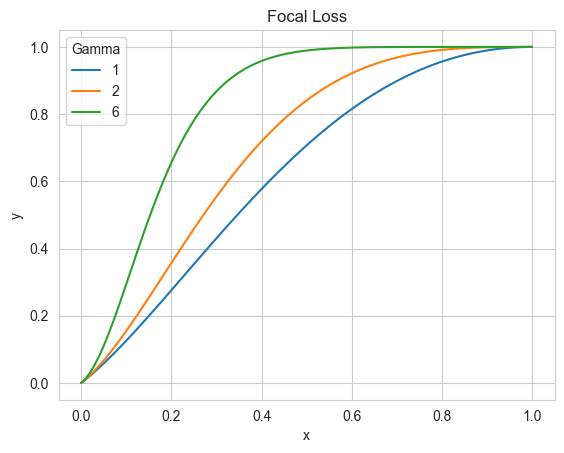

In [21]:
sns.lineplot(x='x', y='value', hue='variable', 
             data=pd.melt(df, ['x']))
plt.legend(title='Gamma')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Focal Loss')
plt.savefig(out / "focal_loss.pdf")

In [4]:
import json
path = Path("C:/Users/piano/Desktop/ffhq-dataset-v2.json")
with open(path) as f:
    data = json.load(f)


In [11]:
d = {}
for key in data.keys():
    k = data[key]["metadata"]["date_uploaded"].split("-")[0]
    if k not in d:
        d[k] = 0
    d[k] += 1
keys = list(d.keys())
keys.sort()
vals = [d[k] for k in keys]

Text(0.5, 1.0, 'FFHQ Dataset Date Uploaded')

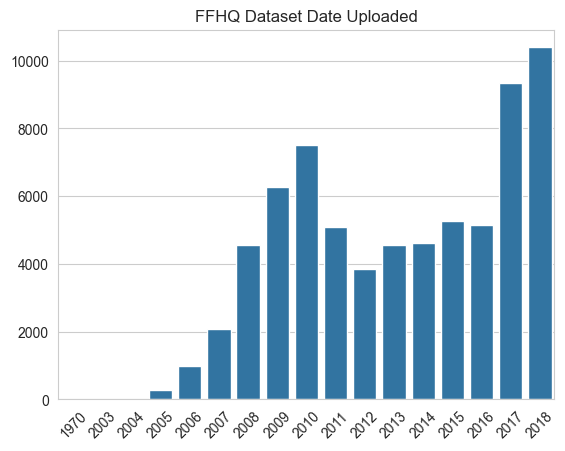

In [14]:
sns.barplot(x=keys, y=vals)
plt.xticks(rotation=45)
plt.title("FFHQ Dataset Date Uploaded")

In [3]:
run.config

{'epochs': 10,
 'workers': 12,
 'chunk_size': 100,
 'data_ratio': 1,
 'group_name': 'stable_rl_12_1',
 'ltn_config': 'stable_rl',
 'float_dtype': 'float32',
 'random_seed': 1300,
 'data_category': 'all',
 'labeled_ratio': 0.05,
 'minibatch_size': 32,
 'shuffle_buffer_size': 10000,
 'test_minibatch_size': 2048,
 'epochs_of_pretraining': 1,
 'p_universal_quantifier': 12,
 'with_clustering_axioms': False,
 'a_existential_quantifier': 1,
 'p_existential_quantifier': 5,
 'training_steps_per_epoch': 100,
 'types_hidden_layer_sizes': [512, 256, 256, 128, 128],
 'with_mereological_axioms': True,
 'bounding_box_minimal_size': 6,
 'partof_hidden_layer_sizes': [512, 256, 256, 128, 128],
 'max_a_existential_quantifier': 5,
 'max_p_existential_quantifier': 5,
 'min_a_existential_quantifier': 1,
 'min_p_existential_quantifier': 1,
 'schedule_a_existential_quantifier': 'linear',
 'schedule_p_existential_quantifier': 'linear'}